In [522]:
import pandas as pd
import numpy as np
import time
import nba_api
import pandas.io.sql as psql

np.set_printoptions(suppress=True)

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE,f_regression, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

import matplotlib.pyplot as plt

import importnb

import import_ipynb
from database_interaction import Nba_DB

#Try this tomorrow for feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from yellowbrick.cluster import KElbowVisualizer

In [524]:
#Class that manages the clustering algorithm
class Clustering_Algorithm:
    query = ""
    n_components = 0
    queried_data = pd.DataFrame()
    algorithm_data = pd.DataFrame()
    
    def __init__(self, queried_data, n_components = 0):
        self.queried_data = queried_data
        self.n_components = n_components
        #self.get_data()
    
        
    #Execute query and return resulting data
    def get_data(self):
        try: 
            db_conn = Nba_DB()
            self.queried_data = db_conn.execute_query(self.query)
            self.algorithm_data = self.queried_data.copy().drop('player_name', axis = 1)
            db_conn.close_connection()
        except:
            print('Error in trying to connect to DB and Execute Query (Clustering_Algorithm: get_data())')
        

    
    #Start preparing the selected data for the clustering algorithm    
    def start_data_prep(self):
        #Drop rows with low number of games played (< 5)
        try:
            self.drop_low_gp()
        except:
            print('Low GP Drop Failed Clustering_Algorithm: start_data_prep()')
            
        #Next run label_encoding on the data
        try:
            self.check_label_encode()
        except:
            print('Check Label Encode Failed Clustering_Algorithm: start_data_prep()')
            
        #Next convert any columns that need to be to per game basis
        try:
            self.check_per_game_conversion()
        except:
            print('Check Per Game Conversion Failed Clustering_Algorithm: start_data_prep()')
        
        #Next scale the data       
        try:
            self.scale_data()
        except:
            print('Data Scaling Failed Clustering_Algorithm: start_data_prep()')
            
        #Get PCA components       
        try:
            self.run_pca()
        except:
            print('PCA components Clustering_Algorithm: start_data_prep()')
            
        #Run KElbow Visualizer       
        try:
            self.run_kelbow()
        except:
            print('KElbow Failed Clustering_Algorithm: start_data_prep()')
        
        #Run run_optimal_cluster_scores        
        try:
            self.run_optimal_cluster_scores()
        except:
            print('run_optimal_cluster_scores Failed Clustering_Algorithm: start_data_prep()')

            
        #Run KMeans Clustering       
        try:
            self.run_k_means()
        except:
            print('KMEans Failed Clustering_Algorithm: start_data_prep()')
        
            
    #Drop data with less than 5 games played in the season
    def drop_low_gp(self):
        self.algorithm_data = self.algorithm_data[self.algorithm_data['gp'] > 5]
        self.queried_data = self.queried_data[self.queried_data['gp'] > 5]
        
    #Check each columns data type, and transform to int if necessary
    def check_label_encode(self):
        for col in self.algorithm_data:
            if self.algorithm_data[col].dtype == object:
                try:
                    self.algorithm_data[col] = self.label_encode(self.algorithm_data[col])
                    self.algorithm_data[col] = self.algorithm_data[col].apply(float)
                except:
                    print('Error in trying to label encode object column (Clustering_Algorithm: label_encode())')
                
    #Converts object column to label encoding            
    def label_encode(self, column):
        labelencoder = LabelEncoder()
        column = labelencoder.fit_transform(column)
        return column
    
    #Convert stats that aren't on a per game basis to a per game basis
    def check_per_game_conversion(self):
        #Columns that should be converted to a per game basis
        #Need GP column
        columns_to_convert = ['fg2m','fg2a', 'fg3m', 'fg3a', 'restricted_area_fgm', 'restricted_area_fga',
       'in_the_paint_non_ra_fgm', 'in_the_paint_non_ra_fga','mid_range_fgm', 'mid_range_fga',
        'left_corner_3_fgm', 'left_corner_3_fga','right_corner_3_fgm', 'right_corner_3_fga',
        'above_the_break_3_fgm','above_the_break_3_fga',  'backcourt_fgm','backcourt_fga', 'corner_3_fgm', 'corner_3_fga',]
        
        for col in self.algorithm_data:
            if col in columns_to_convert:
                try:
                    self.algorithm_data[col] = self.convert_per_game(self.algorithm_data[col], self.algorithm_data['gp'])
                except:
                    print('could not convert to per game (Clustering_Algorithm: convert_per_game())')
        self.algorithm_data = self.algorithm_data.drop('gp', axis = 1)

    
    #Convert column to a per game basis to a per game basis
    def convert_per_game(self, convert_column, gp_column):
        convert_column = convert_column / gp_column
        
        #Drop the gp data as it should not be included in final dataset
        return convert_column

    #Scale the data
    def scale_data(self):
        self.algorithm_data = StandardScaler().fit_transform(self.algorithm_data)
        
        
    #Run a PCA test on the data to identify how many components to use
    def run_pca(self):
        #Use PCA to reduce the number of features
        pca = PCA(n_components = 'mle', svd_solver = 'full')
        self.algorithm_data = pca.fit_transform(self.algorithm_data)

    #Run KElbow test to figure out number of clusters
    def run_kelbow(self):
        #Using the elbow method to figure out number of clusters
        k_model = KMeans()
        elbow_visual = KElbowVisualizer(k_model, k=(5,25))
        elbow_visual.fit(self.algorithm_data)
        elbow_visual.show()
        
    #Run sillhouete average scoring to find optimal number of clusters
    def run_optimal_cluster_scores(self):
        scores_df = pd.DataFrame()
        for n_clusters in range(5,30):
            clusterer = KMeans(n_clusters=n_clusters, random_state = 1)
            preds = clusterer.fit_predict(self.algorithm_data)
            centers = clusterer.cluster_centers_

            s_score = silhouette_score(self.algorithm_data, preds)
            c_score = calinski_harabasz_score(self.algorithm_data, preds)
            d_score = davies_bouldin_score(self.algorithm_data, preds)
            
            cluster_score_dict = {"n_clusters": n_clusters,
                  "silhouette_score": s_score,
                  "calinski_harabasz_score": c_score,
                  "davies_bouldin_score": d_score}
            #print(cluster_score_dict)
            
            scores_df = scores_df.append(cluster_score_dict, ignore_index = True)
            

        scores_df.set_index('n_clusters', inplace = True)
        display(scores_df)


        #FIGURE OUT HOW TO COME UP WITH AN 'Optimal' number of clusters    
        if self.n_components == 0:
            self.n_components = int(scores_df['davies_bouldin_score'].idxmax())


    #Run the clustering KMeans algorithm
    def run_k_means(self):
        #Try K-Means clustering
        k_means = KMeans(init = 'k-means++', n_clusters = self.n_components)
        label = k_means.fit_predict(self.algorithm_data)
        
        #Getting the Centroids
        centroids = k_means.cluster_centers_
        u_labels = np.unique(label)
        

        #plotting the results:
        for i in u_labels:
            plt.scatter(self.algorithm_data[label == i , 0] , self.algorithm_data[label == i , 1] , label = i)
        plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
        plt.legend()
        plt.show()
        
        #Add clusters to queried data
        self.queried_data['cluster'] = k_means.labels_

    #Return the queried data
    def get_queried_data(self):
        return self.queried_data


In [518]:
query = "SELECT player_name, e_def_rating, pie, e_off_rating, ast_to, e_pace, e_usg_pct, position, ts_pct, fg2a, fg2_pct, fg3a, fg3_pct, in_the_paint_non_ra_fga ,in_the_paint_non_ra_fg_pct, corner_3_fga, corner_3_fg_pct, gp FROM players where season = '2016-17'"

In [519]:
cluster = Clustering_Algorithm(query)#, 13)

successfully connected
connection closed


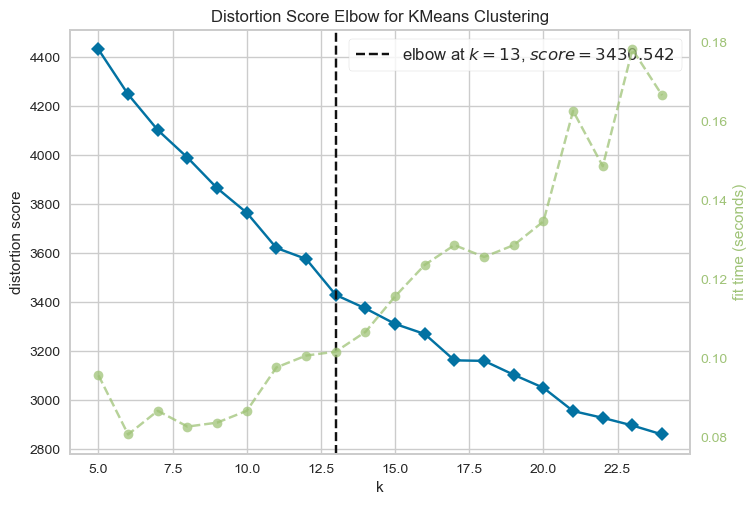

,silhouette_score,calinski_harabasz_score,davies_bouldin_score
n_clusters,,,
5.0,0.136379,71.168889,2.024686
6.0,0.121112,62.846365,2.061277
7.0,0.105374,57.091996,2.117578
8.0,0.108454,52.083442,1.988785
9.0,0.101579,49.275238,2.050769
10.0,0.093159,45.707854,1.991226
11.0,0.109261,42.677652,1.962477
12.0,0.098253,41.649324,1.899139
13.0,0.090134,39.664908,1.970159


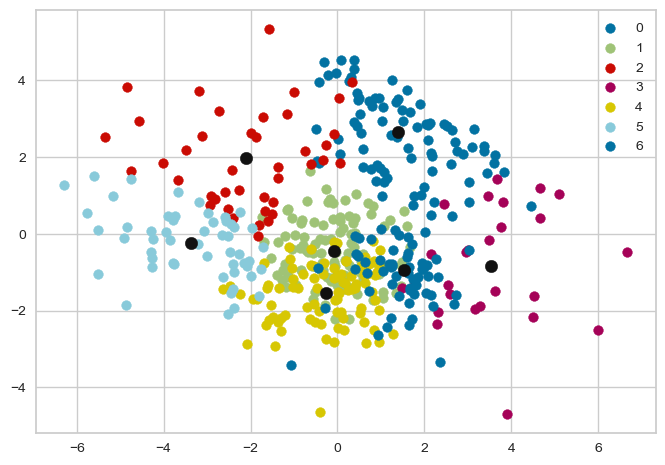

In [520]:
cluster.start_data_prep()

In [521]:
cluster.queried_data.loc[cluster.queried_data['cluster'] == 5, ['player_name', 'position', 'cluster']]

,player_name,position,cluster
5,al horford,PF,5
36,avery bradley,PG,5
48,bradley beal,SG,5
64,cj mccollum,SG,5
68,carmelo anthony,PF,5
76,chris paul,PG,5
85,d'angelo russell,SG,5
89,damian lillard,PG,5
92,danilo gallinari,PF,5
114,dennis schroder,PG,5
